# Configuración, Librerías y Descarga de Datos

## Importación de Librerías y Configuración

In [22]:
# 1.1 Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de Machine Learning Clásicos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Preprocesamiento y Validación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Configuración visual
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



/root
/root/.config
/root/.config/kaggle
Descargando el dataset 'titanic'...
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Descomprimiendo archivos...
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

✅ Dataset Titanic descargado y listo para usar.
gender_submission.csv  kaggle.json  test.csv  titanic.zip  train.csv


## Descargar dataset desde Kaggle (opcional)

In [ ]:
# 1.2 Descarga de Datos (Tu código específico)
import kaggle
%cd
%cd .config
!mkdir -p kaggle # El -p evita error si ya existe
%cd kaggle
!chmod 600 /root/.config/kaggle/kaggle.json

print("Descargando el dataset 'titanic'...")
!kaggle competitions download -c titanic

print("Descomprimiendo archivos...")
!unzip -o titanic.zip # -o sobreescribe si ya existen para no preguntar

print("\n✅ Dataset Titanic descargado y listo para usar.")
!ls

# Carga y Exploración Inicial de Datos

## Carga de Datos y División Inicial

In [23]:
# Carga de datos
# Asumiendo que el unzip dejó los archivos en el directorio actual o root
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
passenger_ids = test['PassengerId'] # Guardamos esto para el submission final

print(f"Tamaño Train: {train.shape}")
print(f"Tamaño Test: {test.shape}")
train.head()

Tamaño Train: (891, 12)
Tamaño Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Limpieza y Ingeniería de Características

## Unificación de Datasets y Extracción de Características

In [ ]:
# Unimos para procesar juntos (limpieza consistente)
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# --- 3.1 Rellenar Valores Nulos ---
# Edad: Rellenamos con la mediana (es más robusto que el promedio)
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

# Fare: Rellenamos con la mediana
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

# Embarked: Rellenamos con la moda (el más común, 'S')
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])

## Imputación de Nulos y Mapeo de Categorías

In [ ]:
# --- 3.2 Creación de Nuevas Características ---

# A. Título (Title): Extraemos Mr, Mrs, Miss, etc. del nombre
dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Agrupamos títulos raros
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# B. Tamaño de Familia (FamilySize)
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# C. Viaja Solo (IsAlone)
dataset['IsAlone'] = 0
dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# D. Binning de Edad (AgeBin) y Tarifa (FareBin) - Opcional para modelos de árboles, útil para análisis
dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

## Limpieza Final y Separación de Datasets

In [24]:

# --- 3.3 Codificación (Mapping) ---
# Convertir texto a números para que los modelos entiendan

# Sexo
dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Embarked
dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Title
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
dataset['Title'] = dataset['Title'].map(title_mapping)
dataset['Title'] = dataset['Title'].fillna(0)

# --- 3.4 Eliminar columnas que ya no sirven ---
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'AgeBin', 'FareBin']
dataset = dataset.drop(drop_elements, axis=1)

# Separamos de nuevo en Train y Test
train = dataset[:train_len]
test = dataset[train_len:]
# Añadimos la columna objetivo a train (se perdió al concatenar si no tuvimos cuidado, pero aquí la recuperamos del split original si es necesario, aunque concat lo maneja bien con NaN en test)
train['Survived'] = train['Survived'].astype(int)

# Eliminamos Survived del test (es lo que queremos predecir)
test = test.drop('Survived', axis=1)

print("Datos procesados exitosamente.")
train.head()

Datos procesados exitosamente.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,22.0,1,0,7.2500,0,1,2,0
1,1,1,1,38.0,1,0,71.2833,1,3,2,0
2,1,3,1,26.0,0,0,7.9250,0,2,1,1
3,1,1,1,35.0,1,0,53.1000,0,3,2,0
4,0,3,0,35.0,0,0,8.0500,0,1,1,1


# Análisis Exploratorio Visual (EDA) para Ejecutivos

## Matriz de Correlación

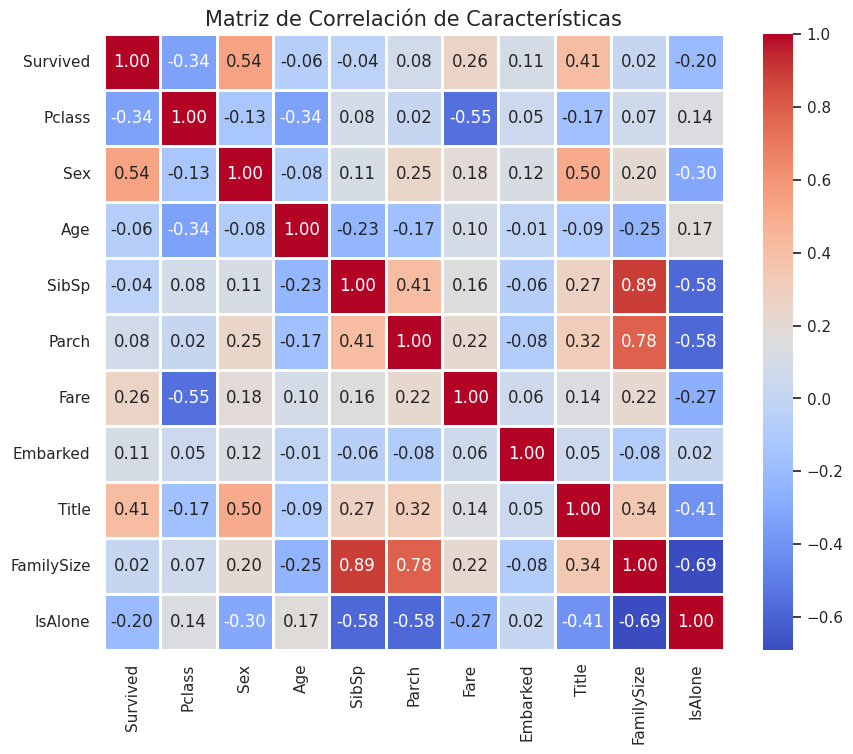

In [31]:
# 4.1 Mapa de Correlación (Heatmap)
# Ayuda a ver qué variables influyen más en 'Survived'
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Matriz de Correlación de Características', fontsize=15)
plt.show()


## Probabilidad de Supervivencia por Clase y Sexo

In [ ]:
# 4.2 Supervivencia por Clase y Sexo (Gráfico de impacto)
plt.figure(figsize=(10, 5))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, palette='muted')
plt.title('Probabilidad de Supervivencia por Clase y Sexo', fontsize=15)
plt.ylabel('Probabilidad de Sobrevivir (0 a 1)')
plt.xlabel('Clase del Pasajero (1 = Alta)')
plt.legend(title='Sexo (0=H, 1=M)', loc='upper left')
plt.show()


## Supervivencia según Tamaño de Familia

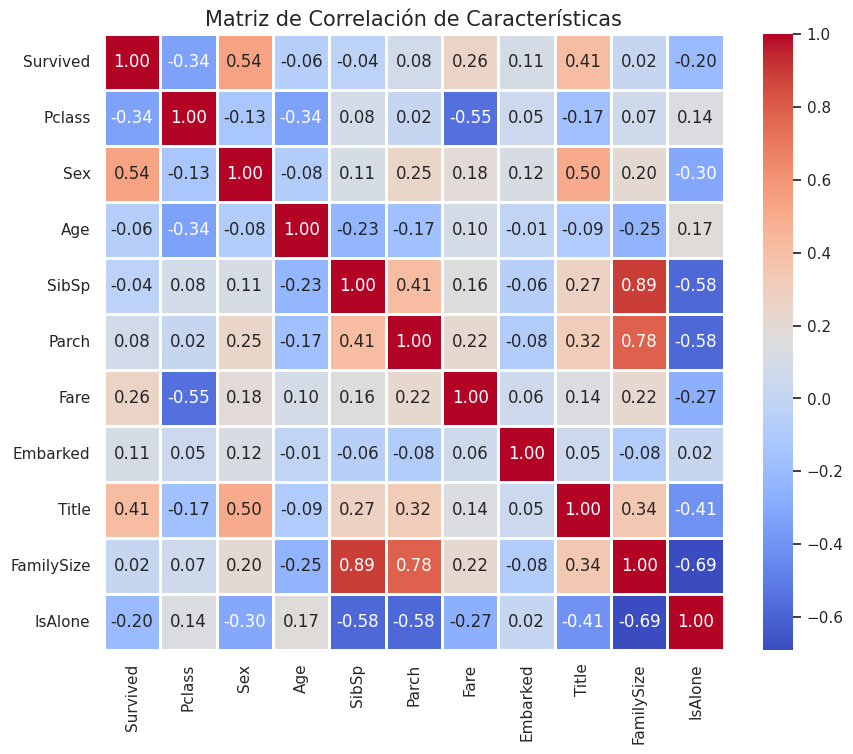

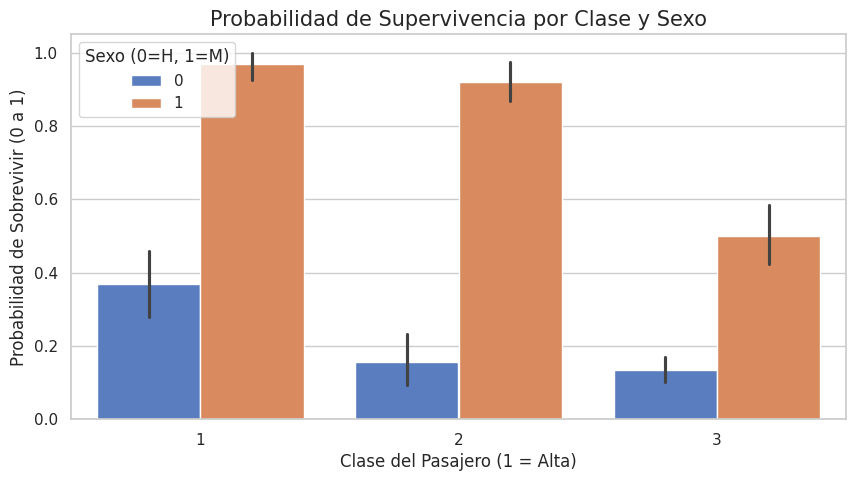

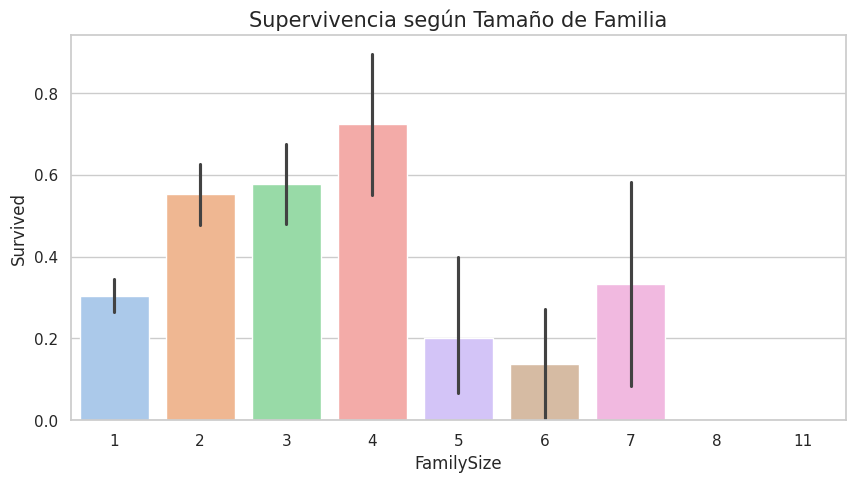

In [25]:


# 4.3 Supervivencia por Tamaño de Familia
plt.figure(figsize=(10, 5))
sns.barplot(x='FamilySize', y='Survived', data=train, palette='pastel')
plt.title('Supervivencia según Tamaño de Familia', fontsize=15)
plt.show()

# Preparación Final para Machine Learning

## Escalado de Datos y División Train/Validation

In [26]:
# Separar X e y
X = train.drop("Survived", axis=1)
y = train["Survived"]
X_test_submit = test.copy() # Para el submission final

# Escalar datos (Importante para Redes Neuronales y SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_submit)

# Dividir en Train y Validación para medir rendimiento localmente
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelado y Cross-Validation (Comparativa)

## Definición y Evaluación de Modelos Clásicos

In [27]:
# Diccionario de modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

print("Entrenando modelos clásicos...")
for name, model in models.items():
    # Entrenar
    model.fit(X_train, y_train)
    # Predecir
    y_pred = model.predict(X_val)
    # Evaluar
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Entrenando modelos clásicos...
Logistic Regression Accuracy: 0.7933
Support Vector Machine Accuracy: 0.8212
Random Forest Accuracy: 0.8268
XGBoost Accuracy: 0.8324


## Modelo con Redes neuronales


Entrenando Red Neuronal...
Neural Network Accuracy: 0.8101


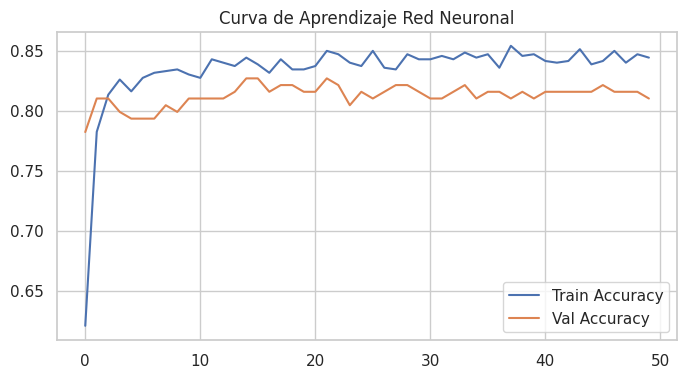

In [34]:
# Definir arquitectura
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Capa de entrada
    Dropout(0.2), # Evitar Overfitting
    Dense(32, activation='relu'), # Capa oculta
    Dense(1, activation='sigmoid') # Salida binaria (0 o 1)
])

# Compilar
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
print("\nEntrenando Red Neuronal...")
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Evaluar
_, nn_acc = nn_model.evaluate(X_val, y_val, verbose=0)
results["Neural Network"] = nn_acc
print(f"Neural Network Accuracy: {nn_acc:.4f}")

# Gráfico de aprendizaje
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Curva de Aprendizaje Red Neuronal')
plt.legend()
plt.show()

# Resultados

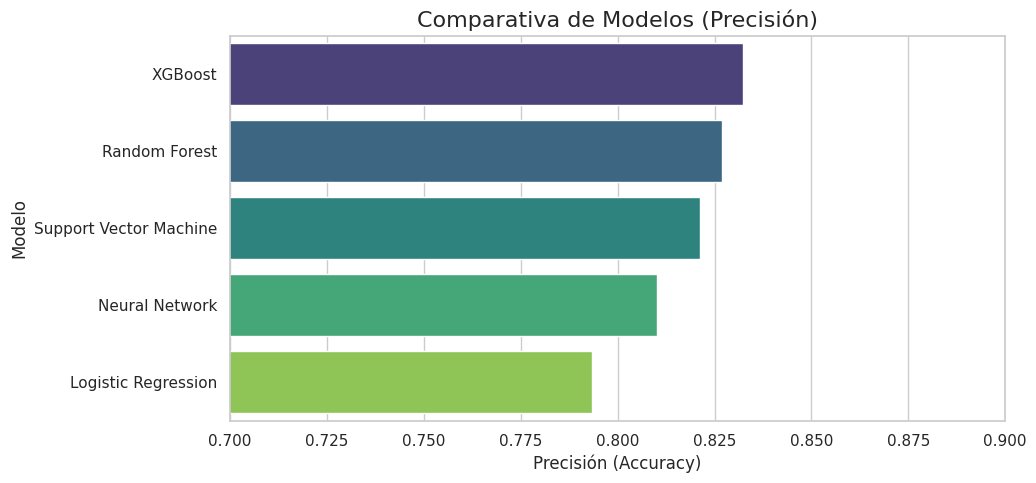

El mejor modelo es:
Modelo       XGBoost
Accuracy    0.832402
Name: 3, dtype: object


In [29]:
# Crear DataFrame de resultados
results_df = pd.DataFrame(list(results.items()), columns=['Modelo', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Modelo', data=results_df, palette='viridis')
plt.xlim(0.7, 0.9) # Zoom en el rango relevante
plt.title('Comparativa de Modelos (Precisión)', fontsize=16)
plt.xlabel('Precisión (Accuracy)')
plt.show()

print("El mejor modelo es:")
print(results_df.iloc[0])

# Características relevantes para la supervivencia
## Características para modelo Random Forest

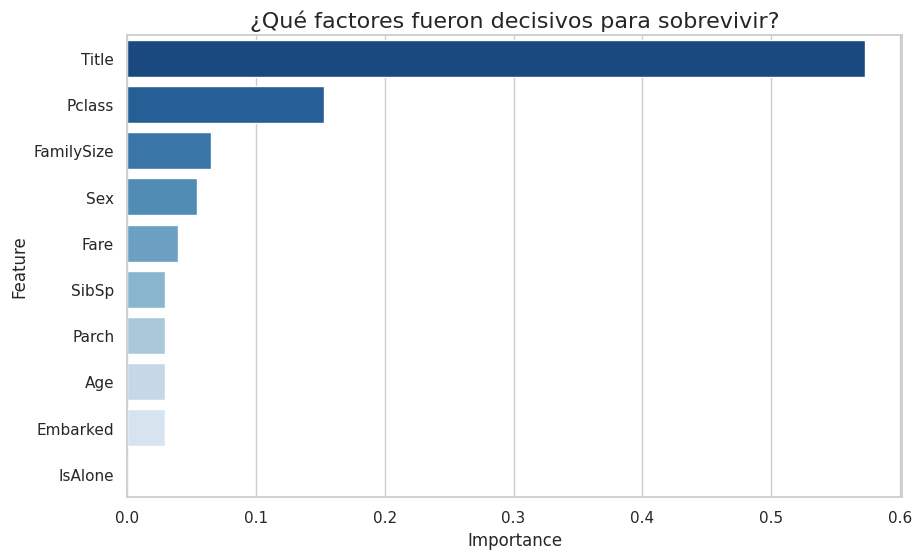

In [40]:
# Usamos el modelo Random Forest ya entrenado
rf_model = models["XGBoost"]
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='Blues_r')
plt.title('¿Qué factores fueron decisivos para sobrevivir?', fontsize=16)
plt.show()